라이브러리

In [1]:
import pandas as pd
import numpy as np
from keras.utils import *
from sklearn.preprocessing import *
from keras import backend as K
from keras.models import load_model
from keras.layers import LSTM, Dense, concatenate, Input
from sklearn.ensemble import GradientBoostingRegressor
from keras.models import Model
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.font_manager as fm
from matplotlib.dates import DateFormatter
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# 모델명(= 파일명) 설정
tank = 1
model_name = 'Test230721_tank1_lstm_crop720_only-feed'

In [2]:
# r_squared 평가 함수
def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - ss_res/(ss_tot + K.epsilon()))

데이터셋 설정

In [3]:
#자포니카 훈련 데이터
japonica_training_food_supply_tb = pd.read_csv("eeldata/data/Training/Origin/Management/Japonica/food_supply_tb.csv")
japonica_training_sensor_val_tb = pd.read_csv("eeldata/data/Training/Origin/Sensor/Japonica/sensor_val_tb.csv")

#자포니카 검증 데이터
japonica_validation_food_supply_tb = pd.read_csv("eeldata/data/Validation/Origin/Management/Japonica/food_supply_tb.csv")
japonica_validation_sensor_val_tb = pd.read_csv("eeldata/data/Validation/Origin/Sensor/Japonica/sensor_val_tb.csv")


In [4]:
# 자포니카 사료 공급 데이터 정제
# null제거
japonica_training_food_supply_tb = japonica_training_food_supply_tb[japonica_training_food_supply_tb['feed_quantity'].notnull()]
japonica_validation_food_supply_tb = japonica_validation_food_supply_tb[japonica_validation_food_supply_tb['feed_quantity'].notnull()]

# 시계열 데이터 변환
japonica_training_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_training_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_training_food_supply_tb["feed_dt"] = japonica_training_food_supply_tb["feed_dt"].apply(str)
japonica_training_food_supply_tb["feed_dt"] = japonica_training_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)
japonica_validation_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_validation_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].apply(str)
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)

In [5]:
# 자포니카 센서 데이터 정제

# 한 개 탱크
japonica_training_sensor_val_tb = japonica_training_sensor_val_tb[japonica_training_sensor_val_tb['tank_id']==tank]
japonica_validation_sensor_val_tb = japonica_validation_sensor_val_tb[japonica_validation_sensor_val_tb['tank_id']==tank]

#시계열 변환
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].apply(str)
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_training_sensor_val_tb['mea_dt'] = pd.to_datetime(japonica_training_sensor_val_tb['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].apply(str)
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_validation_sensor_val_tb['mea_dt'] = pd.to_datetime(japonica_validation_sensor_val_tb['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')

# 시계열 데이터의 개수 확인
training_counts = japonica_training_sensor_val_tb.groupby(japonica_training_sensor_val_tb['mea_dt'].dt.date).size()
validation_counts = japonica_validation_sensor_val_tb.groupby(japonica_validation_sensor_val_tb['mea_dt'].dt.date).size()

# 개수가 1440이 아닌 시계열 삭제
to_delete = training_counts[training_counts != 1440].index
japonica_training_sensor_val_tb = japonica_training_sensor_val_tb[~japonica_training_sensor_val_tb['mea_dt'].dt.date.isin(to_delete)]
to_delete = validation_counts[validation_counts != 1440].index
japonica_validation_sensor_val_tb = japonica_validation_sensor_val_tb[~japonica_validation_sensor_val_tb['mea_dt'].dt.date.isin(to_delete)]

#시계열 데이터 문자 타입으로 변경
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].dt.strftime('%Y-%m-%d %H:%M')
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].dt.strftime('%Y-%m-%d %H:%M')
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)


In [6]:
# 자포니카 훈련 데이터 및 시계열 데이터 병합
japonica_training = pd.merge(left = japonica_training_sensor_val_tb, right = japonica_training_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])
japonica_validation = pd.merge(left = japonica_validation_sensor_val_tb, right = japonica_validation_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])

japonica_training['mea_dt'] = pd.to_datetime(japonica_training['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')
japonica_validation['mea_dt'] = pd.to_datetime(japonica_validation['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')

# 사용할 features 선택
feature_origin = ['tank_id','mea_dt', 'do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']
japonica_training_features = japonica_training[feature_origin]
japonica_validation_features = japonica_validation[feature_origin]

# nan 값 처리 (먹이를 주지 않았을 경우는 급여량이 0이니까)
japonica_training_features = japonica_training_features.fillna(0)
japonica_validation_features = japonica_validation_features.fillna(0)

# 날짜 데이터를 인덱스로 전환
japonica_training_features.set_index('mea_dt', inplace=True)
japonica_validation_features.set_index('mea_dt', inplace=True)

# 인덱스 순으로 데이터를 정렬
japonica_training_data = japonica_training_features.sort_index()
japonica_validation_data = japonica_validation_features.sort_index()

# 8월 1달간 데이터만 추출
japonica_training_data = japonica_training_data.loc['2021-07-21 00:00':'2021-09-10 23:59']
japonica_validation_data = japonica_validation_data.loc['2021-07-21 00:00':'2021-09-10 23:59']

In [7]:
japonica_training_features_X = japonica_training_data[['feed_quantity']]
japonica_training_features_y = japonica_training_data[['do_mg']]

japonica_validation_features_X = japonica_validation_data[['feed_quantity']]
japonica_validation_features_y = japonica_validation_data[['do_mg']]

In [8]:
japonica_training_features_X_chunks = np.asarray(japonica_training_features_X, dtype=np.float64)
japonica_training_features_X_chunks = japonica_training_features_X_chunks.reshape((-1, 720, 1))
japonica_training_features_y_chunks = np.asarray(japonica_training_features_y, dtype=np.float64)
japonica_training_features_y_chunks = japonica_training_features_y_chunks.reshape((-1, 720, 1))

japonica_validation_features_X_chunks = np.asarray(japonica_validation_features_X, dtype=np.float64)
japonica_validation_features_X_chunks = japonica_validation_features_X_chunks.reshape((-1, 720, 1))
japonica_validation_features_y_chunks = np.asarray(japonica_validation_features_y, dtype=np.float64)
japonica_validation_features_y_chunks = japonica_validation_features_y_chunks.reshape((-1, 720, 1))

In [9]:
# shape확인
nCar = japonica_training_features_X_chunks.shape[0] # 데이터 개수
nVar = japonica_training_features_X_chunks.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_training_features_y_chunks.shape[0] # 데이터 개수
nVar = japonica_training_features_y_chunks.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_X_chunks.shape[0] # 데이터 개수
nVar = japonica_validation_features_X_chunks.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_y_chunks.shape[0] # 데이터 개수
nVar = japonica_validation_features_y_chunks.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 90 nVar: 1
nCar: 90 nVar: 720
nCar: 90 nVar: 1
nCar: 90 nVar: 720


LSTM 모델 학습 (학습시에만 사용, 그외에는 불필요)

In [12]:
# LSTM 모델 생성
model = Sequential()
model.add(LSTM(128, input_shape=(720, 1), return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(720, activation='linear'))
 
model.summary()

# mae와 r_squared 평가함수 추가.
model.compile(optimizer='adam', loss='mse', metrics=['mae', r_squared])


checkpoint = ModelCheckpoint(model_name + '_best.h5', monitor='val_loss', save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

# ModelCheckpoint : 검증 손실이 낮아진 경우에 최적의 모델을 저장
# EarlyStopping : 검증 손실이 일정 기간동안 향상되지 않으면 학습을 조기 종료
# ReduceLROnPlateau : 검증 손실이 개선되지 않으면 학습률을 조정하는 등의 동작 수행.


hist = model.fit(japonica_training_features_X_chunks, japonica_training_features_y_chunks, epochs = 1000, batch_size = 32, validation_data=(japonica_validation_features_X_chunks, japonica_validation_features_y_chunks), callbacks=[checkpoint, early_stop, reduce_lr])
model.save(model_name+'.h5')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 720, 128)          66560     
_________________________________________________________________
lstm_7 (LSTM)                (None, 720, 64)           49408     
_________________________________________________________________
lstm_8 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_2 (Dense)              (None, 720)               23760     
Total params: 152,144
Trainable params: 152,144
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
3/3 [==============================] - 5s 610ms/step - loss: 78.5355 - mae: 8.7790 - r_squared: -55.8900 - val_loss: 78.4806 - val_mae: 8.7759 - val_r_squared: -59.7794
Epoch 2/1000
3/3 [==============================] - 0s 140ms/ste

Epoch 41/1000
3/3 [==============================] - 0s 157ms/step - loss: 23.2455 - mae: 4.6598 - r_squared: -17.1818 - val_loss: 22.7108 - val_mae: 4.6021 - val_r_squared: -16.3607
Epoch 42/1000
3/3 [==============================] - 0s 166ms/step - loss: 22.4743 - mae: 4.5763 - r_squared: -15.0448 - val_loss: 21.9552 - val_mae: 4.5194 - val_r_squared: -15.7743
Epoch 43/1000
3/3 [==============================] - 0s 153ms/step - loss: 21.7243 - mae: 4.4938 - r_squared: -14.5227 - val_loss: 21.2227 - val_mae: 4.4377 - val_r_squared: -15.2058
Epoch 44/1000
3/3 [==============================] - 0s 160ms/step - loss: 21.0051 - mae: 4.4125 - r_squared: -14.6212 - val_loss: 20.5096 - val_mae: 4.3568 - val_r_squared: -14.6526
Epoch 45/1000
3/3 [==============================] - 0s 199ms/step - loss: 20.2930 - mae: 4.3320 - r_squared: -13.1340 - val_loss: 19.8223 - val_mae: 4.2774 - val_r_squared: -14.1194
Epoch 46/1000
3/3 [==============================] - 0s 189ms/step - loss: 19.6072 - 

Epoch 132/1000
3/3 [==============================] - 1s 209ms/step - loss: 1.7173 - mae: 0.9883 - r_squared: -0.1892 - val_loss: 1.7051 - val_mae: 0.9835 - val_r_squared: -0.1785
Epoch 133/1000
3/3 [==============================] - 0s 153ms/step - loss: 1.7005 - mae: 0.9816 - r_squared: -0.1620 - val_loss: 1.6880 - val_mae: 0.9767 - val_r_squared: -0.1661
Epoch 134/1000
3/3 [==============================] - 0s 169ms/step - loss: 1.6840 - mae: 0.9751 - r_squared: -0.1862 - val_loss: 1.6718 - val_mae: 0.9704 - val_r_squared: -0.1545
Epoch 135/1000
3/3 [==============================] - 0s 162ms/step - loss: 1.6683 - mae: 0.9688 - r_squared: -0.1542 - val_loss: 1.6565 - val_mae: 0.9645 - val_r_squared: -0.1435
Epoch 136/1000
3/3 [==============================] - 0s 160ms/step - loss: 1.6536 - mae: 0.9632 - r_squared: -0.1396 - val_loss: 1.6421 - val_mae: 0.9590 - val_r_squared: -0.1332
Epoch 137/1000
3/3 [==============================] - 0s 164ms/step - loss: 1.6388 - mae: 0.9573 - r

3/3 [==============================] - 0s 187ms/step - loss: 1.4121 - mae: 0.8886 - r_squared: -0.0325 - val_loss: 1.4117 - val_mae: 0.8885 - val_r_squared: 0.0171
Epoch 224/1000
3/3 [==============================] - 0s 146ms/step - loss: 1.4117 - mae: 0.8885 - r_squared: 0.0328 - val_loss: 1.4116 - val_mae: 0.8885 - val_r_squared: 0.0171
Epoch 225/1000
3/3 [==============================] - 0s 153ms/step - loss: 1.4116 - mae: 0.8885 - r_squared: 0.0227 - val_loss: 1.4116 - val_mae: 0.8886 - val_r_squared: 0.0171
Epoch 226/1000
3/3 [==============================] - 0s 161ms/step - loss: 1.4116 - mae: 0.8886 - r_squared: 0.0263 - val_loss: 1.4116 - val_mae: 0.8886 - val_r_squared: 0.0171

Epoch 00226: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 227/1000
3/3 [==============================] - 0s 153ms/step - loss: 1.4116 - mae: 0.8886 - r_squared: 0.0167 - val_loss: 1.4116 - val_mae: 0.8886 - val_r_squared: 0.0171
Epoch 228/1000
3/3 [======================

모델 평가

In [10]:
# 모델 평가 함수
def grapeNEva(model, X_test_shape, y_test, feed, y_test_shape):
    X_pred = model.predict(X_test_shape)
    X_pred = np.asarray(X_pred, dtype=np.float64)
    X_pred = X_pred.reshape((-1))
    print(len(X_pred))

    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='sensor do')  # x축에 년월일, y축에 값
    plt.plot(y_test.index, X_pred, color='red', label='prediction do')  # x축에 년월일, y축에 시분
    plt.plot(y_test.index, feed, color='green', marker='o', linestyle='None', label='feed_quantity')  # x축에 년월일, y축에 시분
    plt.xlabel('date')
    plt.ylabel('do')
    plt.title(model_name)
    plt.legend(['sensor do','prediction do','feed_quantity'])
    plt.show()
    
    # 평가 생성
    result = model.evaluate(X_test_shape, y_test_shape)
    print("MSE // MAE // R-squared ", result)

In [11]:
# r_squared가 따로 만들어서 추가해준 함수기 때문에 불러올 때도 추가해서 불러야한다.
model = load_model(model_name+'.h5', custom_objects={'r_squared': r_squared})

2023-07-23 06:34:10.640528: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-23 06:34:11.582976: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7951 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe MIG 1g.10gb, pci bus id: 0000:d5:00.0, compute capability: 8.0


[[ 1.92037672e-02  5.01644798e-02  9.29859206e-02  1.16275661e-02
   1.97003153e-03 -1.59659311e-02 -4.09786403e-02  2.84744590e-03
   5.73129803e-02  4.13296856e-02 -1.88955870e-02  9.53948721e-02
  -8.48878175e-03 -4.14599059e-03  5.13512269e-02 -7.59338168e-03
   7.65868053e-02  2.49552876e-02 -1.06863044e-02 -1.05887003e-01
   6.27452210e-02 -9.49061587e-02  3.43514755e-02 -2.29519885e-02
  -5.41777797e-02  1.01678595e-01  2.61115488e-02  3.84326763e-02
  -1.40899913e-02  8.38644952e-02  6.82936460e-02 -6.57700971e-02
  -1.51738962e-02  3.23565975e-02  8.70647952e-02 -1.04961663e-01
   3.25194187e-03  3.43825109e-02 -9.50572789e-02 -6.01414172e-03
   2.86109280e-02 -1.48754530e-02 -1.99120995e-02  1.37730427e-02
  -1.00337928e-02 -8.20937604e-02 -1.06548116e-01 -1.01774469e-01
   4.04137895e-02 -2.40665432e-02 -7.75662586e-02  9.20862779e-02
   2.10109763e-02 -9.02058482e-02 -6.25310605e-03  5.65057695e-02
  -7.38269314e-02  4.65082414e-02 -1.53046977e-02 -4.52357307e-02
   1.87994

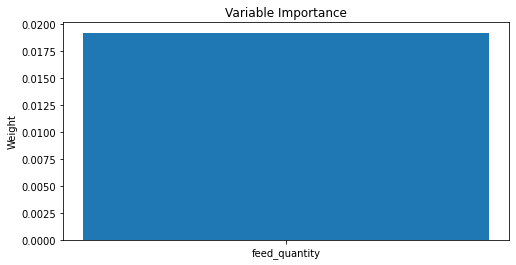

In [12]:
# 가중치를 통해 변수 중요도 획득
weights = model.layers[0].get_weights()[0]
print(weights)


# 변수 중요도 시각화
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(range(1), weights[:, 0])
ax.set_xticks(range(1))
ax.set_xticklabels(['feed_quantity'])
ax.set_ylabel('Weight')
ax.set_title('Variable Importance')
plt.show()

In [13]:
japonica_validation_features_X

,feed_quantity
mea_dt,
2021-07-21 00:00:00,0.0
2021-07-21 00:01:00,0.0
2021-07-21 00:02:00,0.0
2021-07-21 00:03:00,0.0
2021-07-21 00:04:00,0.0
...,...
2021-09-08 23:55:00,0.0
2021-09-08 23:56:00,0.0
2021-09-08 23:57:00,0.0


In [14]:
X = japonica_validation_data.loc['2021-07-21 00:00':'2021-09-08 23:59']
X_test = X[['feed_quantity']]

X_test_reshape = np.asarray(X_test, dtype=np.float64)
X_test_reshape = X_test_reshape.reshape((-1, 720, 1))

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 90 nVar: 1


In [15]:
y_test = X[['do_mg']]


y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 720, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 64800 nVar: 1
nCar: 90 nVar: 720


2023-07-23 06:34:13.927769: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-07-23 06:34:15.872053: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8200
2023-07-23 06:34:16.973281: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


64800


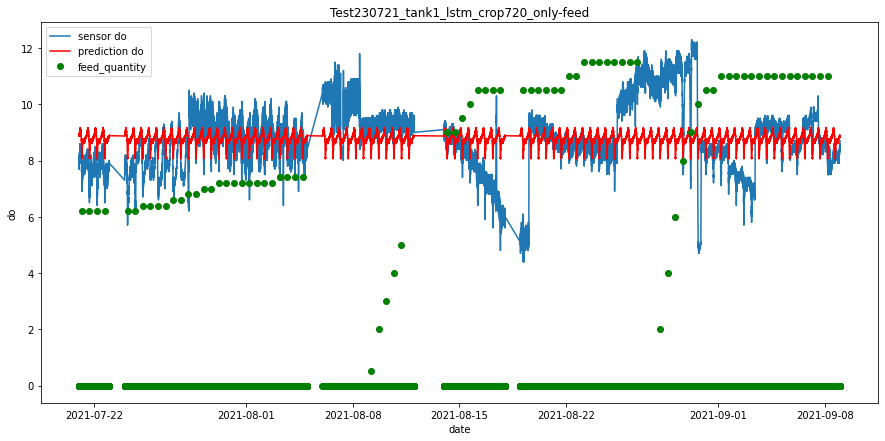

3/3 [==============================] - 1s 47ms/step - loss: 1.4116 - mae: 0.8886 - r_squared: 0.0171
MSE // MAE // R-squared  [1.4115632772445679, 0.8886053562164307, 0.017085591331124306]


In [16]:
grapeNEva(model, X_test_reshape, y_test, X_test[['feed_quantity']], y_test_reshape)

In [38]:
X = japonica_validation_data.loc['2021-08-02 00:00':'2021-08-03 23:59']
X_test = X[['feed_quantity']]

X_test_reshape = np.asarray(X_test, dtype=np.float64)
X_test_reshape = X_test_reshape.reshape((-1, 720, 1))

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 4 nVar: 1


In [39]:
y_test = X[['do_mg']]


y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 720, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 2880 nVar: 1
nCar: 4 nVar: 720


2880


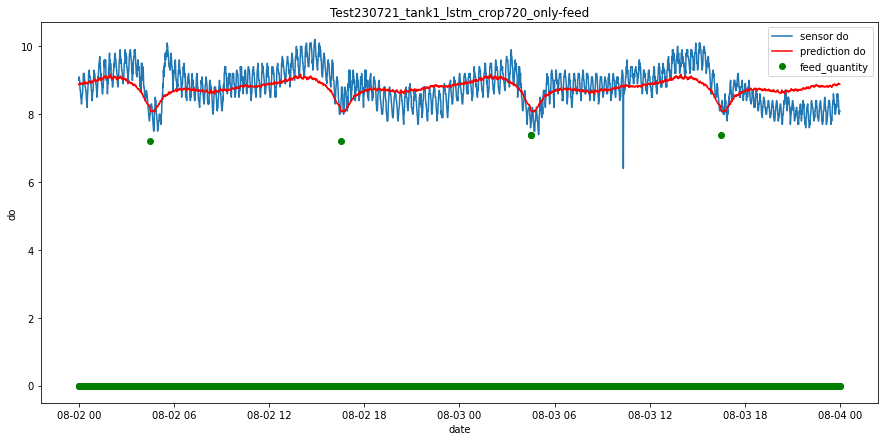

1/1 [==============================] - 0s 89ms/step - loss: 0.2138 - mae: 0.3746 - r_squared: 0.2689
MSE // MAE // R-squared  [0.21381926536560059, 0.3746100068092346, 0.2688550353050232]


In [40]:
grapeNEva(model, X_test_reshape, y_test, X_test[['feed_quantity']], y_test_reshape)

In [35]:
X = japonica_validation_data.loc['2021-08-01 00:00':'2021-08-08 23:59']
X_test = X[['feed_quantity']]

X_test_reshape = np.asarray(X_test, dtype=np.float64)
X_test_reshape = X_test_reshape.reshape((-1, 720, 1))

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 14 nVar: 1


In [36]:
y_test = X[['do_mg']]


y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 720, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 10080 nVar: 1
nCar: 14 nVar: 720


10080


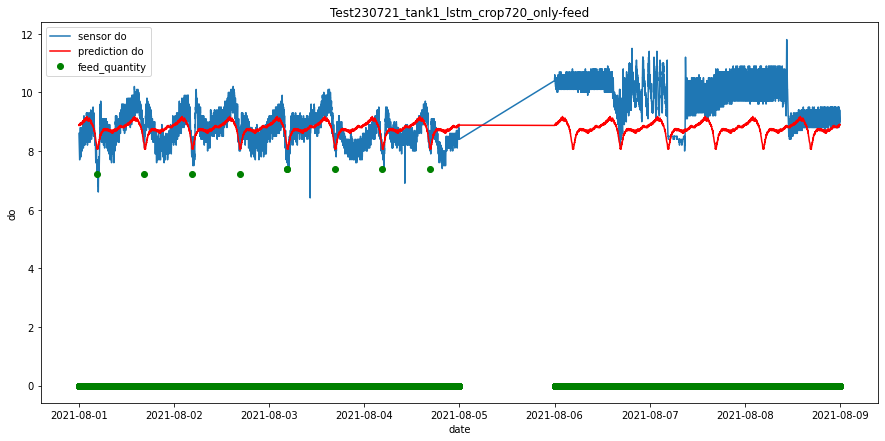

1/1 [==============================] - 0s 57ms/step - loss: 0.8258 - mae: 0.7014 - r_squared: -0.2359
MSE // MAE // R-squared  [0.8258228302001953, 0.7013601064682007, -0.23590779304504395]


In [37]:
grapeNEva(model, X_test_reshape, y_test, X_test[['feed_quantity']], y_test_reshape)

In [43]:
X = japonica_validation_data.loc['2021-08-03 00:00':'2021-08-03 11:59']
X_test = X[['feed_quantity']]

X_test_reshape = np.asarray(X_test, dtype=np.float64)
X_test_reshape = X_test_reshape.reshape((-1, 720, 1))

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 1 nVar: 1


In [44]:
y_test = X[['do_mg']]


y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 720, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 720 nVar: 1
nCar: 1 nVar: 720


720


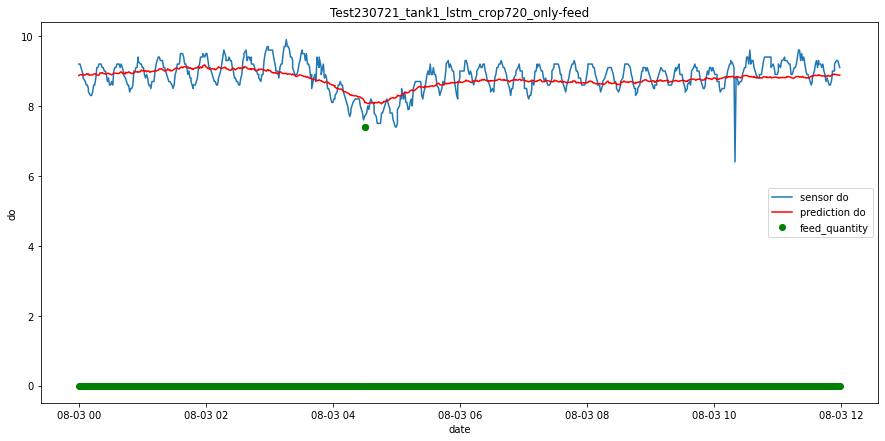

1/1 [==============================] - 0s 85ms/step - loss: 0.1147 - mae: 0.2761 - r_squared: 0.3982
MSE // MAE // R-squared  [0.11465777456760406, 0.2760959267616272, 0.39819765090942383]


In [45]:
grapeNEva(model, X_test_reshape, y_test, X_test[['feed_quantity']], y_test_reshape)

nCar: 1 nVar: 1
nCar: 720 nVar: 1
nCar: 1 nVar: 720
720


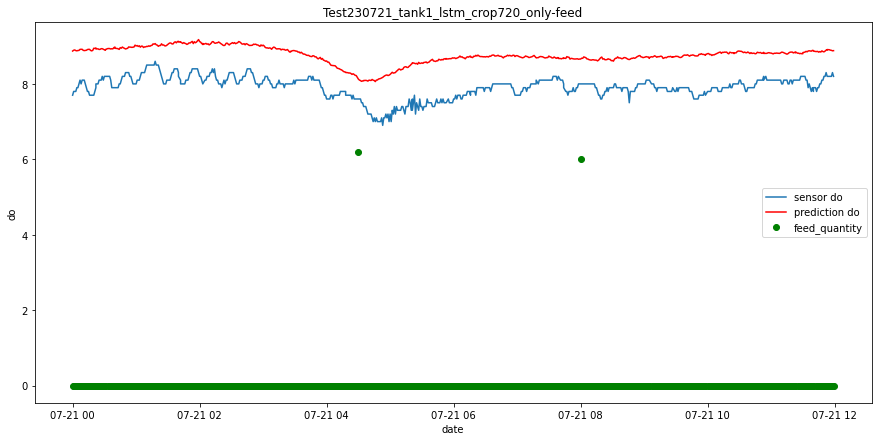

1/1 [==============================] - 0s 61ms/step - loss: 0.7566 - mae: 0.8518 - r_squared: -8.0744
MSE // MAE // R-squared  [0.756632387638092, 0.8517796993255615, -8.074396133422852]


In [26]:
X = japonica_validation_data.loc['2021-07-21 00:00':'2021-07-21 11:59']
X_test = X[['feed_quantity']]

X_test_reshape = np.asarray(X_test, dtype=np.float64)
X_test_reshape = X_test_reshape.reshape((-1, 720, 1))

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

y_test = X[['do_mg']]


y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 720, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

grapeNEva(model, X_test_reshape, y_test, X_test[['feed_quantity']], y_test_reshape)